# KNN

Ukljucivanje potreblih biblioteka

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from termcolor import colored
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.io import arff
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV


from sklearn.neighbors import KNeighborsClassifier 
import plotly.express as px
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_curve, roc_auc_score




Ucitavanje podataka

In [2]:

data = pd.read_csv('/home/user/Desktop/IP/sredjeni_podaci.csv')
print(data.shape)



(8378, 123)


In [3]:

print(data['Unnamed: 0'])
data.drop('Unnamed: 0',axis = 1,inplace = True)


0          0
1          1
2          2
3          3
4          4
        ... 
8373    8373
8374    8374
8375    8375
8376    8376
8377    8377
Name: Unnamed: 0, Length: 8378, dtype: int64


Razdvajamo ciljni atribut od ostalih atributa,pa podatke delimo na trening i test skup

In [4]:
Y = data['match']
X = data.drop('match',axis = 1)

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=112)

Pomocne fukcije za proveru kvaliteta modela.Kod je preuzet iz materijala sa vezbi:

In [6]:
 def report(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Izvestaj o klasifikaciji za model{} nad {} podacima".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report(y, y_pred))
    print("---------------------------------------------------------------------------------")
    
    print(colored("Matrica konfuzije za model {} nad {} podacima ".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(pd.DataFrame(confusion_matrix(y, y_pred), columns=['1', '0'], index=['1', '0']))
    print("---------------------------------------------------------------------------------")

Pre primene KNN algoritma moramo da normalizujemo podatke, a pre toga cemo da proverimo da li postoje vrednost van granica i kako oni uticu na ovaj model.
Za proveru vrednosti van granica koristicemo IQR.


In [7]:

def IQR(data, feature_names):
    
    iqr = pd.DataFrame(0, index=feature_names, columns=['lower', 'min', 'num_lower', 'upper', 'max', 'num_upper', 'percantage'])
    for name in feature_names:

        (Q1, Q3) = X[name].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        upper = Q3 + (1.5 * IQR)
        lower = Q1 - (1.5 * IQR)
        
        iqr.loc[name, 'upper'] = upper
        iqr.loc[name, 'lower'] = lower

        num_of_out_lower = (X[name] < lower).sum()
        num_of_out_upper = (X[name] > upper).sum()

        percentage = round((num_of_out_lower + num_of_out_upper) / X.shape[0] * 100)

        iqr.loc[name, 'num_lower'], iqr.loc[name, 'num_upper'], iqr.loc[name, 'percantage']  = num_of_out_lower, num_of_out_upper, percentage
        iqr.loc[name, 'min'], iqr.loc[name, 'max'] = min(X[name]), max(X[name])    
    return iqr

In [8]:
feature_names = X.columns
iqr = IQR(X_train,feature_names)
print(iqr)

                    lower   min  num_lower  upper   max  num_upper  percantage
wave                 -5.0   1.0          0   27.0  21.0          0           0
gender               -1.5   0.0          0    2.5   1.0          0           0
age                  18.0  18.0          0   34.0  55.0        173           2
age_o                18.0  18.0          0   34.0  55.0        173           2
d_age                -5.0   0.0          0   11.0  37.0        355           4
...                   ...   ...        ...    ...   ...        ...         ...
d_like               -1.5   0.0          0    2.5   2.0          0           0
d_guess_prob_liked   -3.0   0.0          0    5.0   2.0          0           0
met                   0.0   0.0          0    0.0   8.0        359           4
decision             -1.5   0.0          0    2.5   1.0          0           0
decision_o           -1.5   0.0          0    2.5   1.0          0           0

[121 rows x 7 columns]


Kolona pergantage nam govori koliko procenata podataka su outlieri.

In [9]:
for p in iqr['percantage']:
    if p > 0:
        print(p)
print('Maksimalan procenat outliera je: ', iqr['percantage'].max())

2
2
4
7
7
7
14
6
9
11
20
1
19
2
38
36
7
14
6
9
11
20
10
2
4
3
26
1
19
2
38
36
2
2
1
6
2
2
49
1
19
6
12
1
4
Maksimalan procenat outliera je:  49


Na osnovu ovoga zakljucujemo da postoji veliki broj elemenata van granica (u nekoj koloni cak 49%), pa zato mislim da bi trebalo da na neki nacin obradim outliere.Mislim da je najbolje da outliere zamenim medijanom, zato sto bih u slucaju brisanja izgubila veliki procenat podata.

# Normalizacija originalnih podataka i primena algoritma knn

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
knn = KNeighborsClassifier()
knn.fit(X_train,Y_train)
report(knn,X_train,Y_train,text = "TRENING")
report(knn,X_test,Y_test,text = "TEST")


Izvestaj o klasifikaciji za modelKNeighborsClassifier nad TRENING podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      4898
           1       0.79      0.47      0.59       966

    accuracy                           0.89      5864
   macro avg       0.85      0.72      0.76      5864
weighted avg       0.88      0.89      0.88      5864

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad TRENING podacima 
---------------------------------------------------------------------------------
      1    0
1  4780  118
0   516  450
---------------------------------------------------------------------------------
Izvestaj o klasifikaciji za modelKNeighborsClassifier nad TEST podacima
---------------------------------------------------------------------------------
       

Model pravi jako veliki broja gresaka gre instance cija je stvarna klasa 1 klasifikuje kao instance klase 0.

# Outliere menjamo medijanom, vrsimo normalizaciju nad izmenjenim podacima i pozivamo KNN

Htela sam da proverim da li cu zamenom outliera medijanom uspeti da malo popravim model.

In [11]:
def replace_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   upper = df[~(df>(q3+1.5*IQR))].max()

   lower = df[~(df<(q1-1.5*IQR))].min()

   df = np.where(df > upper,

       df.median(),

       np.where(

           df < lower,

           df.median(),

           df

           )

       )

   return df

In [12]:
column_num = len(feature_names)
for i in range(0,column_num):
    column_name = feature_names[i];
    p = iqr.iat[i,6];
    if p >= 1:
        data[column_name] = replace_outliers_IQR(data[column_name])

 Pozivamo IQR da proverimo da li sada imamo outliera i u kojoj meri

In [13]:
Y = data['match'];
X = data.drop('match',axis = 1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=12)
iqr2 = IQR(X_train,feature_names)
print(iqr2['percantage'].max())


16


Kada smo jednom outliere zamenili medijanom, nismo uspeli da izgubimo sve outliere,a ako zelimo da nemamo vrednosti van granica mozemo da pozovemo vise puta istu fju.Sada radimo opet normalizaciju, pa primenjujem algoritam knn

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [15]:

knn = KNeighborsClassifier()
knn.fit(X_train,Y_train)
report(knn,X_train,Y_train,text = "TRENING")
report(knn,X_test,Y_test,text = "TEST")

Izvestaj o klasifikaciji za modelKNeighborsClassifier nad TRENING podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      4898
           1       0.80      0.45      0.58       966

    accuracy                           0.89      5864
   macro avg       0.85      0.71      0.76      5864
weighted avg       0.88      0.89      0.88      5864

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad TRENING podacima 
---------------------------------------------------------------------------------
      1    0
1  4788  110
0   529  437
---------------------------------------------------------------------------------
Izvestaj o klasifikaciji za modelKNeighborsClassifier nad TEST podacima
---------------------------------------------------------------------------------
       

Model je skoro jednako los kao i pre ovog postupka.

# Podesavanje hiper parametara

In [16]:

params_grid = {'n_neighbors': range(10, 30, 5),
               'weights': ['uniform', 'distance'],
                'p': [1, 2]}

estimator = GridSearchCV(KNeighborsClassifier(), params_grid, cv=4, verbose=4,scoring = 'f1')
estimator.fit(X_train, Y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV 1/4] END n_neighbors=10, p=1, weights=uniform;, score=0.199 total time=   1.5s
[CV 2/4] END n_neighbors=10, p=1, weights=uniform;, score=0.207 total time=   1.4s
[CV 3/4] END n_neighbors=10, p=1, weights=uniform;, score=0.215 total time=   1.3s
[CV 4/4] END n_neighbors=10, p=1, weights=uniform;, score=0.141 total time=   1.4s
[CV 1/4] END n_neighbors=10, p=1, weights=distance;, score=0.312 total time=   1.4s
[CV 2/4] END n_neighbors=10, p=1, weights=distance;, score=0.294 total time=   1.3s
[CV 3/4] END n_neighbors=10, p=1, weights=distance;, score=0.339 total time=   1.3s
[CV 4/4] END n_neighbors=10, p=1, weights=distance;, score=0.224 total time=   1.3s
[CV 1/4] END n_neighbors=10, p=2, weights=uniform;, score=0.264 total time=   0.3s
[CV 2/4] END n_neighbors=10, p=2, weights=uniform;, score=0.266 total time=   0.2s
[CV 3/4] END n_neighbors=10, p=2, weights=uniform;, score=0.241 total time=   0.2s
[CV 4/4] END n_neighbo

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(10, 30, 5), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='f1', verbose=4)

Proveravamo koji su optimalni parametni KNN algoritma koje smo dobili GreadSearchom, kao i koji je najveci f1-score

In [17]:
print(estimator.best_params_)

{'n_neighbors': 10, 'p': 2, 'weights': 'distance'}


In [18]:
print(estimator.best_score_)

0.337686852214641


In [19]:
report(estimator.best_estimator_, X_train, Y_train,text = "TRAIN")
report(estimator.best_estimator_, X_test,Y_test,text = "TEST")

Izvestaj o klasifikaciji za modelKNeighborsClassifier nad TRAIN podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4898
           1       1.00      1.00      1.00       966

    accuracy                           1.00      5864
   macro avg       1.00      1.00      1.00      5864
weighted avg       1.00      1.00      1.00      5864

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad TRAIN podacima 
---------------------------------------------------------------------------------
      1    0
1  4898    0
0     0  966
---------------------------------------------------------------------------------
Izvestaj o klasifikaciji za modelKNeighborsClassifier nad TEST podacima
---------------------------------------------------------------------------------
           

Koriscenjem grid search algoritma dobili smo model koji se preprilagodio trening podacima.

# BaggingClassifier

In [20]:

baggingKnn = BaggingClassifier(estimator=KNeighborsClassifier(), n_estimators=20)
baggingKnn.fit(X_train, Y_train)

report(baggingKnn, X_train, Y_train,text = "TRENING")
report(baggingKnn, X_test, Y_test, "TEST")

Izvestaj o klasifikaciji za modelBaggingClassifier nad TRENING podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      4898
           1       0.83      0.44      0.58       966

    accuracy                           0.89      5864
   macro avg       0.87      0.71      0.76      5864
weighted avg       0.89      0.89      0.88      5864

---------------------------------------------------------------------------------
Matrica konfuzije za model BaggingClassifier nad TRENING podacima 
---------------------------------------------------------------------------------
      1    0
1  4812   86
0   537  429
---------------------------------------------------------------------------------
Izvestaj o klasifikaciji za modelBaggingClassifier nad TEST podacima
---------------------------------------------------------------------------------
              pr

# Poredjenje modela ROC krivom

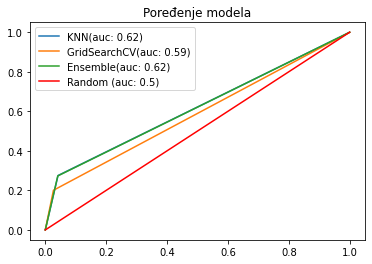

In [21]:
models = [knn, estimator.best_estimator_,baggingKnn]
model_names = ['KNN', 'GridSearchCV','Ensemble']
for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)
    fpr,tpr, _ = roc_curve(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_pred)
    lab = model_name + "(auc: " + str(round(auc, 2)) + ")"
    plt.plot(fpr, tpr, label=lab)

plt.plot([0, 1], [0, 1], label='Random (auc: 0.5)', color='red')
plt.title("Poređenje modela")
plt.legend()
plt.show()


KNN daje mnogo losije rezultate u odnosu na ostale algoritme klasterovanja.Mislim da je to zato sto imamo mnogo vise instanci jedne klase nego instanci druge klase, a posto su u ovom algoritmu od velike vaznosti klase suseda, mislim da je razlog zbog koga imamo jako veliki broj gresaka kod kojih za klasu 1 predvidjamo 0.